# Set-up and loading the data

In [52]:
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer, util, models
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [50]:
# conda install -c conda-forge kneed


Note: you may need to restart the kernel to use updated packages.


In [49]:
path_data = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured'

In [3]:
pipe_sentiment = pipeline(model = 'distilbert-base-uncased-finetuned-sst-2-english')
sent_embedder = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

In [4]:
df_article = pd.read_pickle('art.pkl')

The report already has most of the pre-processing we want done in the pickle state, so we will apply the same changes to the report dataset.

In [7]:
df_report = pd.read_csv(os.path.join(path_data,'report_sentences.csv'))
df_report = df_report[df_report["word count"] > 5]
df_report = df_report[df_report["word count"] < 100]
df_report.rename(columns = {'fname':'company'},inplace = True)

In [8]:
report_sent = df_report['sentence'].tolist()
report_embeddings = sent_embedder.encode(report_sent)
df_report['embeddings'] = list(report_embeddings)

In [9]:
df_report.to_pickle('rep.pkl')

# Analyzing the data

## K-Means clustering

First, we apply k-means clustering on the existing embeddings to identify the sustainability topic clusters within the text. Following Boelders' approach, we first overlap the embeddings to remove the inherent difference in language between the report and the articles (*not sure if this is necessary - maybe I can use those metrics to see whether it improves the clusters or not*). 

### Overlapping the data

We first calculate the centroids as Boelders did and calculate the difference between the two. This difference is then subtracted from one of the embeddings (the article ones) to remove the inherent difference and create new embeddings.

In [12]:
article_centroid = np.mean(df_article['embeddings'].values, axis = 0)
article_centroid

array([-9.44235027e-02, -1.60741899e-02, -1.07839309e-01, -5.83017655e-02,
        1.10452987e-01, -3.76510359e-02, -7.42122531e-02,  3.18790711e-02,
       -7.75863305e-02, -2.36604363e-02, -2.74118558e-02,  7.21719787e-02,
        2.67885998e-03,  1.15407405e-04, -4.98745451e-03,  3.68418880e-02,
       -3.15436870e-02, -1.13471873e-01, -1.98399611e-02, -3.97733487e-02,
       -1.44537399e-02, -1.45254135e-01, -1.59438625e-02, -2.78858896e-02,
       -4.51309904e-02,  3.50095145e-02, -2.32873764e-02, -4.73383367e-02,
       -2.62790341e-02, -5.55212647e-02,  6.18877560e-02,  1.65934995e-01,
       -1.58068817e-02, -2.72126799e-03,  3.95502076e-02,  6.10508136e-02,
        3.04344185e-02, -1.14996582e-01, -1.18035544e-02, -8.64151195e-02,
       -2.45761257e-02, -1.79304108e-01, -9.19723287e-02,  5.04712993e-03,
       -7.67047750e-03,  4.15937565e-02,  8.18394274e-02, -3.87713276e-02,
       -8.43195096e-02, -1.07746400e-01,  8.93482119e-02, -6.98538944e-02,
        1.24672078e-01, -

In [13]:
report_centroid = np.mean(report_embeddings, axis = 0)
report_centroid

array([-1.14413574e-01,  4.59750444e-02, -1.04664780e-01, -5.50850667e-02,
        1.79983720e-01, -5.48050785e-03, -1.09131947e-01,  1.38792722e-02,
       -1.25666499e-01,  3.90087664e-02, -1.88038852e-02,  3.03217582e-02,
        2.31050923e-02,  3.41739506e-02, -5.05602248e-02,  7.32822940e-02,
       -7.15910122e-02, -9.36559960e-02, -3.36410552e-02, -1.19621478e-01,
       -4.17025052e-02, -8.70766118e-02, -3.83998714e-02, -5.58080971e-02,
       -9.37502980e-02,  6.34784847e-02, -2.77733412e-02, -1.08022548e-01,
        6.71895745e-04, -6.45752326e-02,  3.69996279e-02,  1.68576136e-01,
       -2.10998524e-02,  3.52665619e-03,  2.60959025e-02,  8.67811665e-02,
        5.35764582e-02, -1.43497571e-01, -1.66581403e-02, -7.85128996e-02,
        7.51236919e-04, -2.18866631e-01, -1.09839886e-01, -1.53639764e-02,
       -3.46647389e-02,  1.53590441e-02,  6.25568405e-02, -7.82482550e-02,
       -1.79669231e-01, -9.97262448e-02,  1.18610218e-01, -9.02484059e-02,
        8.64770412e-02, -

In [14]:
dif = report_centroid - article_centroid 
# Convert the patents vectors
def difference(org_vec):
    return org_vec + dif

In [15]:
df_art = df_article.copy()
df_rep = df_report.copy()

In [16]:
df_art['new_embeddings'] = df_art['embeddings'].apply(difference)
df_rep['new_embeddings'] = df_rep['embeddings']

### Running the algorithm and plotting a word cloud

In [17]:
# combining the two datasets in preparation for the clustering
df_comb = pd.concat([df_art, df_rep])

In [42]:
#pickling the combined dataset here
df_comb = pd.read_pickle('comb.pkl')

In [54]:
def plot_clusters(df,min_k,max_k):
    embeddings = list(df['new_embeddings'])
    embeddings = np.array(embeddings)
    
    min_clusters = min_k
    max_clusters = max_k
    inertias = []
    silhouette_coefficients = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters = k, init = 'k-means++',random_state = 1542, n_init = 10).fit(embeddings)
        inertias.append(kmeans.inertia_)
        score = silhouette_score(embeddings, kmeans.labels_)
        silhouette_coefficients.append(score)
        
    
    plt.plot(range(min_clusters, max_clusters), inertias, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Scree plot')
    
    plt_sil.plot(range(2, 11), silhouette_coefficients)
    plt_sil.xticks(range(2, 11))
    plt_sil.xlabel("Number of clusters (k)")
    plt_sil.ylabel("Silhouette Coefficient")
    return plt.show(), plt_sil.show()


In [44]:
def add_clusters(df,k):
    embeddings = list(df['new_embeddings'])
    embeddings = np.array(embeddings)
    kmeans = KMeans(n_clusters = k, init = 'k-means++',random_state = 1542, n_init = 10).fit(embeddings)
    clusters = kmeans.labels_
    df['clusters'] = clusters
    return df

In [45]:
def plot_wordcloud(df, cluster):
    cluster_text = ' '.join([sentence for sentence in df[df['clusters'] == cluster]['sentence'].str.lower()])
    word_cloud = WordCloud(collocation_threshold = 2, width = 1000, height = 500, background_color = 'white'
                      ).generate(cluster_text)

    plt.figure(figsize = (10,5))
    plt.imshow(word_cloud)
    plt.axis('off')
    return plt.show

In [55]:
plot_clusters(df_comb, 2, 20)

KeyboardInterrupt: 

In [60]:
df_comb = add_clusters(df_comb, 7) #7 giving the best results - potentially can also add stopwords manually to the wordcloud
# at the very least I could remove the company names from the word cloud results

<function matplotlib.pyplot.show(close=None, block=None)>

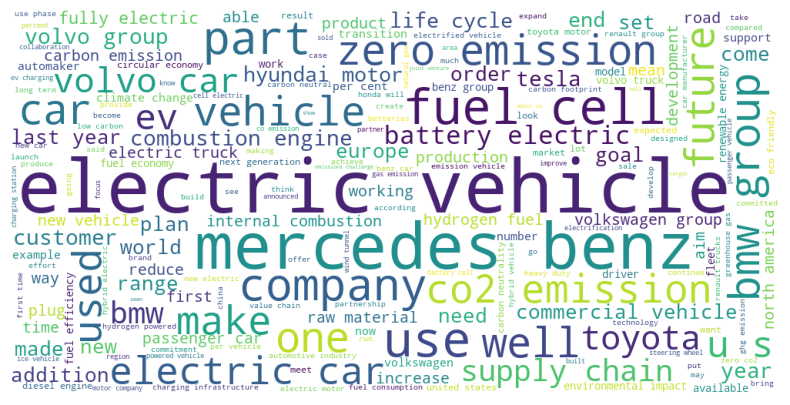

In [61]:
plot_wordcloud(df_comb, 0)

<function matplotlib.pyplot.show(close=None, block=None)>

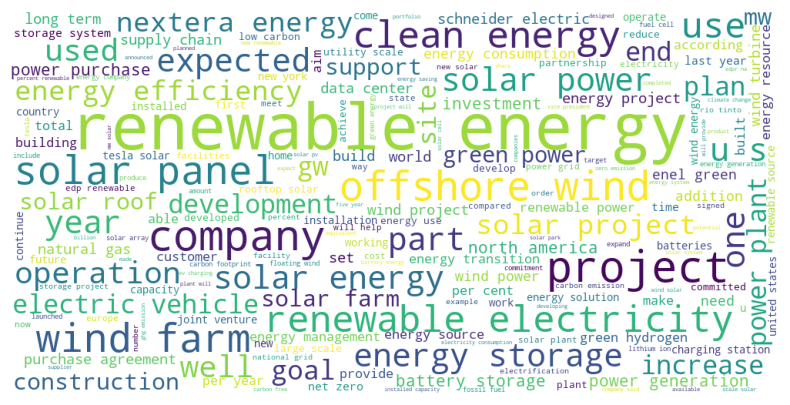

In [62]:
plot_wordcloud(df_comb, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

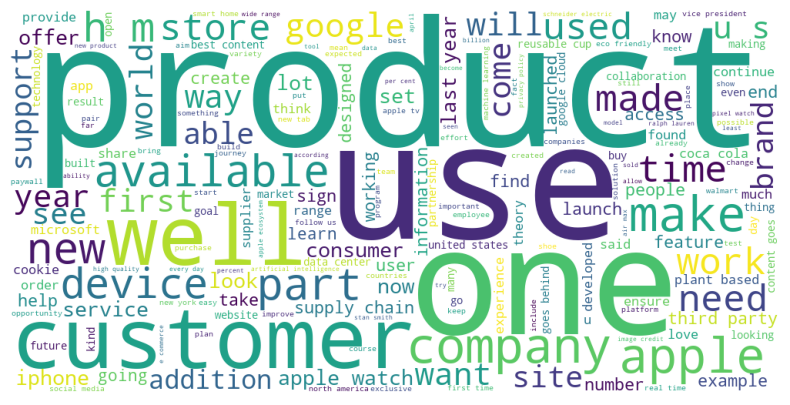

In [63]:
plot_wordcloud(df_comb, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

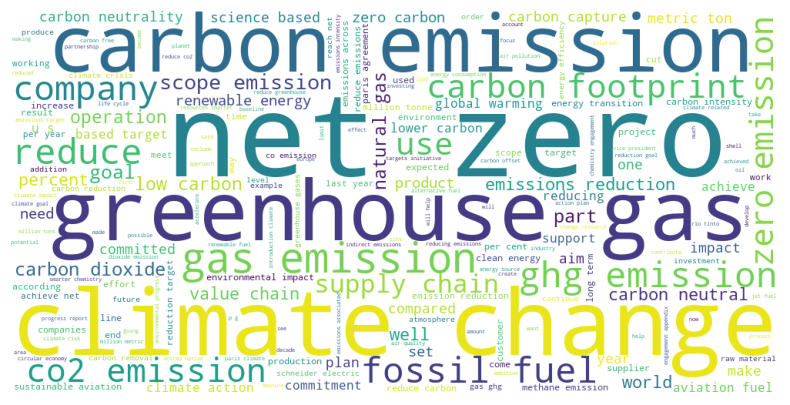

In [64]:
plot_wordcloud(df_comb, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

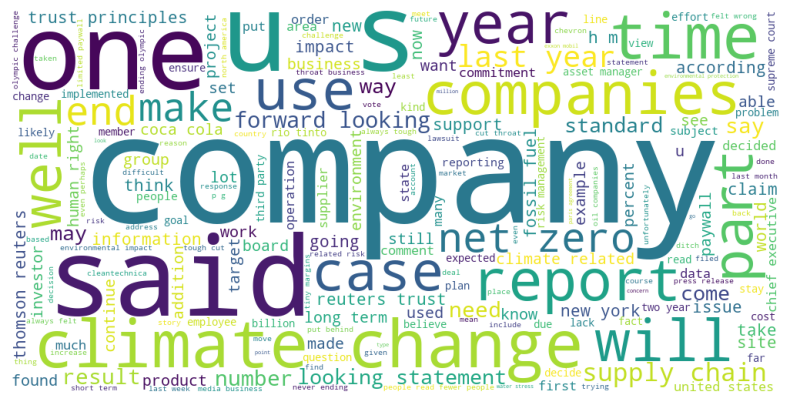

In [65]:
plot_wordcloud(df_comb, 4)

<function matplotlib.pyplot.show(close=None, block=None)>

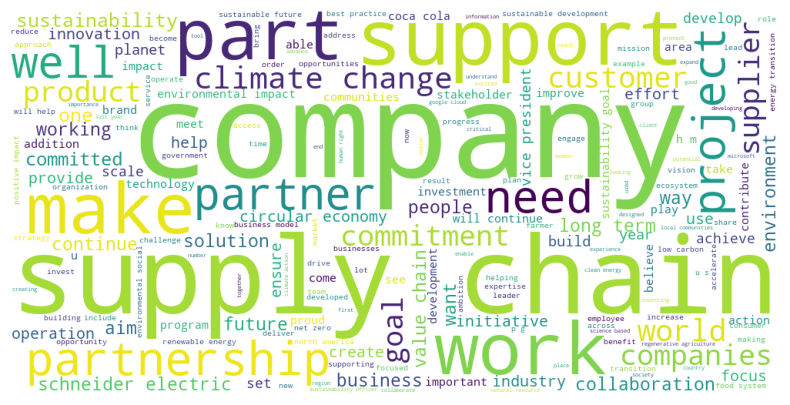

In [66]:
plot_wordcloud(df_comb, 5)

<function matplotlib.pyplot.show(close=None, block=None)>

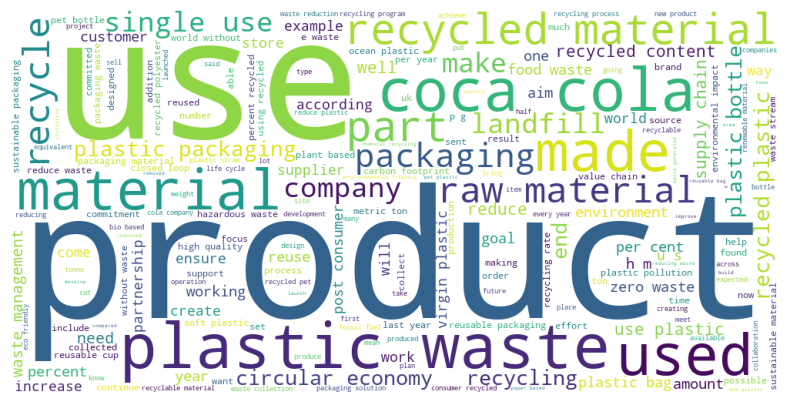

In [67]:
plot_wordcloud(df_comb, 6)

<function matplotlib.pyplot.show(close=None, block=None)>

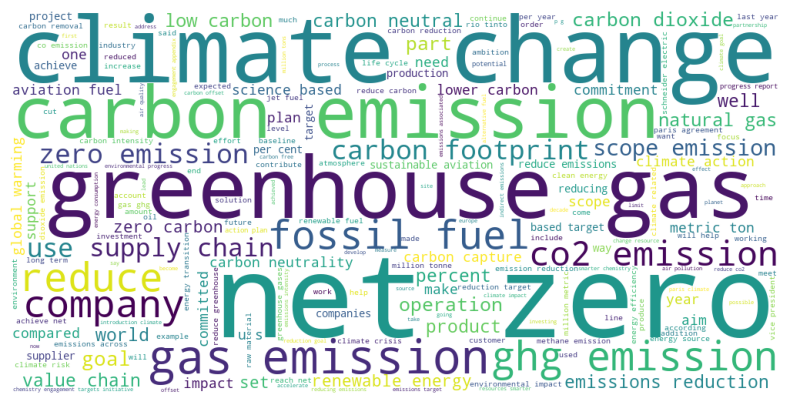

In [46]:
# plot_wordcloud(df_comb, 7)

## Sentiment Analysis

In [68]:
# very inefficient - write this code in a different way
df_comb['sentiment'] = df_comb['sentence'].map(lambda x: pipe_sentiment(x)[0]['label'])
df_comb['sentiment_score'] = df_comb['sentence'].map(lambda x: pipe_sentiment(x)[0]['score'])

Similarly to Kang and Kim we reverse negative scores, so all the scores are on the same scale.

In [89]:
df_comb['sentiment'].value_counts()

POSITIVE    74703
NEGATIVE    55255
Name: sentiment, dtype: int64

In [4]:
df_comb = pd.read_pickle('comb.pkl')

In [5]:
def reverse_score(row):
    if row['sentiment'] == 'NEGATIVE':
        return 1 - row['sentiment_score']
    else:
        return row['sentiment_score']

In [6]:
df_comb['sentiment_score_rev'] = df_comb.apply(reverse_score, axis = 1)

In [7]:
df_comb[(df_comb['company']=='coca-cola')&(df_comb['doc_type']=='report')&(df_comb['sentiment']=='NEGATIVE')]['sentence'].values[13]

'Population growth, climate change, political conflict and forced migration are further straining water infrastructure and supply.'

### Score calculation

Does Boelders' calculation of the greenwashing score actually make sense? He does an average of the weighted scores, but to me that doesn't make any sense - I think you should add them up to get the weighted average of the greenwashing scores for a particular company. *Does it also make sense to do the weighted average? Then we put more emphasis on efforts that are communicated mainly by the company and not paying enough attnetion to the smaller stuff, which may be counterintuitive based on the definitions of greenwashing.*

In [28]:
def gw_score_sent(firm, cluster, df):
    # calculate the average sentiment score for this firm in this cluster across its report
    rep_score = df[(df['company']==firm)&(df['clusters']==cluster)&(df['doc_type']=='report')]['sentiment_score_rev'].mean(skipna=True)
    # calculate the average sentiment score for this firm in this cluster across its news coverage
    news_score = df[(df['company']==firm)&(df['clusters']==cluster)&(df['doc_type']=='news')]['sentiment_score_rev'].mean(skipna=True)
    # for calculating the cluster importance as described by Boelders, we need to divide the number of cluster sentences for this company by its total number of sentences
    cluster_sentences = len(df[(df['company']==firm)&(df['clusters']==cluster)])
    total_sentences = len(df[df['company']==firm])
    cl_importance = cluster_sentences/total_sentences
    return (rep_score-news_score)*cl_importance

In [29]:
gw_score_sent('h&m',3,df_comb)

nan

In [30]:
gw_database = {}
for cluster in list(set(df_comb['clusters'])):
    firm_cluster_score = {}
    for firm in set(df_comb['company']):
        firm_cluster_score[firm] = gw_score_sent(firm, cluster, df_comb)
    gw_database[cluster]= firm_cluster_score


gw_database

{0: {'henkel': -0.007491176337624036,
  'general-mills': nan,
  'enel': 0.0007585749099396478,
  'airbus': 0.023659481018845626,
  'eversource': 0.005571082257539057,
  'hp': 0.003819184920109289,
  'chipotle': nan,
  'danone': nan,
  'bayer': 0.002133258683921392,
  'beiersdorf': nan,
  'inditex': nan,
  'nike': -0.0038388759619767507,
  'cemex': 0.005397089693453653,
  'citi': nan,
  'toyota': 0.11439338781789289,
  'hershey': nan,
  'volvo': 0.027727234020767138,
  'intel': 0.0016040319823516335,
  'blackrock': nan,
  'chevron': 0.007687946544109581,
  'p&g': 0.0018955808286228134,
  'sonoco': nan,
  'pepsico': 0.0034664140694293855,
  'exxon': nan,
  'h&m': nan,
  'hyundai': 0.05786201206326089,
  'boeing': 0.010058352872295511,
  'microsoft': -0.0004651083420216461,
  'edp': -0.0026656997093787564,
  'mondelez': nan,
  'shell': -0.008009028404428962,
  'google': nan,
  'totalenergies': 0.00025246567995397057,
  'ford-motor': 0.048235546411421165,
  'coca-cola': nan,
  'ralph-laure

In [31]:
df_gw = pd.DataFrame.from_dict(gw_database)
df_gw

,0,1,2,3,4,5,6
henkel,-0.007491,-0.007629,0.012023,0.013756,0.004118,0.002563,-0.030222
general-mills,NaN,0.013966,-0.005795,0.019676,0.009944,0.004485,0.007125
enel,0.000759,-0.018271,0.006222,0.001978,0.040981,0.019511,0.000442
airbus,0.023659,0.003928,0.009152,-0.006690,0.046551,0.013631,0.009065
eversource,0.005571,0.065910,0.009005,0.013049,0.077035,0.022740,0.000113
...,...,...,...,...,...,...,...
dupont,0.006339,0.011108,0.008123,0.000057,0.081427,0.015871,0.031506
mcdonald,-0.004740,0.000351,0.027431,0.019437,0.074865,0.019405,0.044869
colgate,-0.002326,0.009628,0.007202,0.014026,0.021664,0.011243,0.060053
nestle,-0.000185,0.000620,0.029275,0.013297,0.020408,0.046627,0.029277


In [32]:
df_gw['total'] = df_gw[[0,1,2,3,4,5,6]].sum(axis = 1)

In [33]:
df_gw.to_csv('sentiment_scores.csv')

In [118]:
df_gw.index

Index(['citi', 'linde', 'mitsubishi', 'colgate', 'hershey', 'mercedes',
       'honda', 'walmart', 'dell', 'tesco', 'general-mills', 'adidas', 'dhl',
       'abb', 'pepsico', 'henkel', 'google', 'starbucks', 'enel', 'h&m',
       'bayer', 'boeing', 'blackrock', 'tesla', 'apple', 'cemex', 'hyundai',
       'beiersdorf', 'diageo', 'komatsu', 'shell', 'p&g', 'rio-tinto',
       'ford-motor', 'inditex', 'edp', 'bmw', 'veolia', 'ralph-lauren',
       'nestle', 'volkswagen', 'sonoco', 'coca-cola', 'mondelez', 'chipotle',
       'airbus', 'mcdonald', 'nextera', 'chevron', 'microsoft', 'danone',
       'volvo', 'hp', 'exxon', 'intel', 'nike', 'schneider-electric', 'dupont',
       'eversource', 'totalenergies', 'toyota', 'ibm', 'renault'],
      dtype='object')

In [93]:
# df2 = df_gw.sum(axis=1)
# pd.DataFrame(df2)

In [37]:
# normalizing the discrepancy score
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [108]:
df_gw['total'] = MinMaxScaler().fit_transform(np.array(df_gw['total']).reshape(-1,1))

In [125]:
list(df_gw['total'])
# dhl has a highly negative value, which is screwing with my min max scaling

[-0.014526464107097677,
 0.024526297525735853,
 -0.0004344109791779259,
 -0.01390499653496612,
 -0.028052503709421278,
 -0.01652601909115136,
 0.0006620948363641546,
 -0.002899031596216812,
 -0.02312877267993558,
 -0.01773464447815073,
 0.011516559062145906,
 -0.01803479872360386,
 -0.1647285783366627,
 0.0006034970809600511,
 0.008945541676726934,
 -0.015500992308267587,
 0.007857287188329619,
 -0.012561814897371008,
 -0.005345648474332699,
 0.0,
 -0.006467779028474902,
 0.0030754207267160725,
 -0.0007019491897175535,
 -0.004361075128059439,
 -0.0002934092595016742,
 0.00356156151658371,
 -0.005610709820950087,
 0.017054969565375153,
 0.002055671575730733,
 0.001027232469956038,
 -0.017852599115650698,
 -0.01313566520457313,
 -0.012435299718741143,
 -0.012427792959079035,
 -0.007399030716735248,
 0.0018263527733760798,
 -0.018184888914199136,
 0.006243166365159097,
 0.007436003348276319,
 0.010554656949650656,
 -0.016522133216883155,
 -0.022930193757481756,
 -0.007153417826402009,
 0.

## Text Similarity

In [18]:
df_report = df_comb[df_comb['doc_type']=='report']
df_article = df_comb[df_comb['doc_type']=='news']
df_report.reset_index(drop = True, inplace = True)
df_article.reset_index(drop = True, inplace = True)

In [19]:
df_similarity = df_report.copy()

In [21]:
similarity_scores = []
for i,row in df_similarity.iterrows():
    # define our query (i.e. claim) and the company it's related to 
    query_embedding = row['embeddings']
    company = row['company']
    cluster = row['clusters']
    # search only the article embeddings/sentences of the specific company
    corpus_embeddings = df_article[(df_article['company']==company)&(df_article['clusters']==cluster)]['embeddings'].values
    top_10 = util.semantic_search(torch.Tensor(query_embedding), torch.Tensor(np.array(list(corpus_embeddings))), top_k = 10)
    try:
        sim_score = pd.DataFrame(top_10[0])['score'].mean()
    except:
        sim_score = 'no sentences'
    similarity_scores.append(sim_score)

df_similarity['sentence_similarity'] = similarity_scores

In [175]:
top_10[0]

[{'corpus_id': 81, 'score': 0.4796932339668274},
 {'corpus_id': 156, 'score': 0.4766523838043213},
 {'corpus_id': 484, 'score': 0.467585027217865},
 {'corpus_id': 246, 'score': 0.46506989002227783},
 {'corpus_id': 234, 'score': 0.4606879651546478},
 {'corpus_id': 345, 'score': 0.45754891633987427},
 {'corpus_id': 322, 'score': 0.45000773668289185},
 {'corpus_id': 227, 'score': 0.4462166726589203},
 {'corpus_id': 11, 'score': 0.44183218479156494},
 {'corpus_id': 317, 'score': 0.43422645330429077}]

In [22]:
gw_database_sim = {}
for cluster in list(set(df_comb['clusters'])):
    firm_cluster_score = {}
    for firm in set(df_comb['company']):
        firm_cluster_score[firm] = df_similarity[(df_similarity['company']==firm)&(df_similarity['clusters']==cluster)&(df_similarity['sentence_similarity']!='no sentences')]['sentence_similarity'].mean(skipna=True)
    gw_database_sim[cluster]= firm_cluster_score


gw_database_sim

{0: {'henkel': 0.307193410065439,
  'general-mills': nan,
  'enel': 0.3073586453612034,
  'airbus': 0.5770016088630217,
  'eversource': 0.25718866961754183,
  'hp': 0.4035098646368299,
  'chipotle': nan,
  'danone': nan,
  'bayer': 0.2108456364867312,
  'beiersdorf': nan,
  'inditex': nan,
  'nike': 0.3162145186747823,
  'cemex': 0.40255425423383717,
  'citi': nan,
  'toyota': 0.598530276705984,
  'hershey': nan,
  'volvo': 0.6099456763240545,
  'intel': 0.24561781156808138,
  'blackrock': nan,
  'chevron': 0.5080124467611313,
  'p&g': 0.233937249651977,
  'sonoco': nan,
  'pepsico': 0.45881001849969233,
  'exxon': nan,
  'h&m': nan,
  'hyundai': 0.6015409134080014,
  'boeing': 0.5197689699069143,
  'microsoft': 0.29582042594750724,
  'edp': 0.16019037537849867,
  'mondelez': nan,
  'shell': 0.43830260461882536,
  'google': nan,
  'totalenergies': 0.45165878699885476,
  'ford-motor': 0.5417353221591101,
  'coca-cola': nan,
  'ralph-lauren': nan,
  'tesla': 0.532363929219392,
  'rio-tin

In [23]:
df_gw_sim = pd.DataFrame.from_dict(gw_database_sim)
df_gw_sim

,0,1,2,3,4,5,6
henkel,0.307193,0.441082,0.316931,0.471574,0.252742,0.515490,0.552531
general-mills,NaN,0.401772,0.317858,0.511924,0.268937,0.500265,0.260843
enel,0.307359,0.529861,0.247507,0.491178,0.324345,0.490653,0.330006
airbus,0.577002,0.485288,0.334677,0.580605,0.338507,0.485650,0.380358
eversource,0.257189,0.513299,0.231859,0.432165,0.351334,0.472154,0.213468
...,...,...,...,...,...,...,...
dupont,0.360307,0.412970,0.300349,0.470131,0.375814,0.574513,0.432614
mcdonald,0.358209,0.507266,0.480616,0.542530,0.401509,0.529817,0.588919
colgate,0.309629,0.231054,0.277209,0.442338,0.230000,0.505484,0.535156
nestle,0.255926,0.441334,0.359633,0.505296,0.327689,0.506255,0.540308


In [24]:
df_gw_sim['average'] = df_gw_sim[[0,1,2,3,4,5,6]].mean(axis = 1)

In [25]:
df_gw_sim['rev_similarity'] = 1 - df_gw_sim['average']
df_gw_sim

,0,1,2,3,4,5,6,average,rev_similarity
henkel,0.307193,0.441082,0.316931,0.471574,0.252742,0.515490,0.552531,0.408221,0.591779
general-mills,NaN,0.401772,0.317858,0.511924,0.268937,0.500265,0.260843,0.376933,0.623067
enel,0.307359,0.529861,0.247507,0.491178,0.324345,0.490653,0.330006,0.388701,0.611299
airbus,0.577002,0.485288,0.334677,0.580605,0.338507,0.485650,0.380358,0.454584,0.545416
eversource,0.257189,0.513299,0.231859,0.432165,0.351334,0.472154,0.213468,0.353067,0.646933
...,...,...,...,...,...,...,...,...,...
dupont,0.360307,0.412970,0.300349,0.470131,0.375814,0.574513,0.432614,0.418100,0.581900
mcdonald,0.358209,0.507266,0.480616,0.542530,0.401509,0.529817,0.588919,0.486981,0.513019
colgate,0.309629,0.231054,0.277209,0.442338,0.230000,0.505484,0.535156,0.361553,0.638447
nestle,0.255926,0.441334,0.359633,0.505296,0.327689,0.506255,0.540308,0.419492,0.580508


In [38]:
df_gw_sim['rev_similarity'] = NormalizeData(df_gw_sim['rev_similarity'])# not sure if this is necessary

In [41]:
df_gw_sim.to_csv('similarity_scores.csv')